In [1]:
import matplotlib.image as mpimg
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2yiq
from collections import defaultdict 
import cv2
%matplotlib inline

In [2]:
img_file = "test2.png"
img_file_scribbled = "test2_s.png"

In [3]:
img = io.imread(img_file)
img_s = io.imread(img_file_scribbled)
print(img.dtype, img.shape)
g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
g_img_s = cv2.cvtColor(img_s, cv2.COLOR_RGB2GRAY)


uint8 (213, 324, 4)


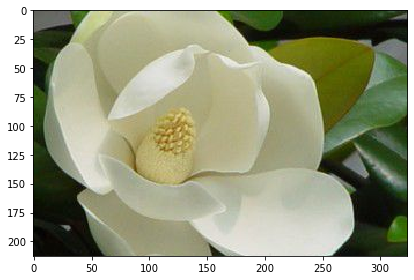

In [4]:
io.imshow(img)

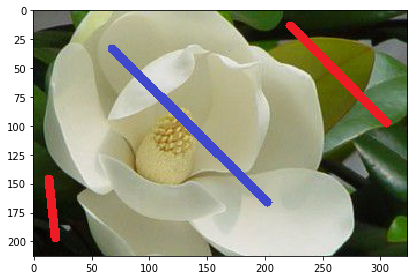

In [5]:
io.imshow(img_s)

In [6]:
scribble = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if g_img[i,j] !=  g_img_s[i,j]:
            scribble.append((i,j))
# print(scribble)

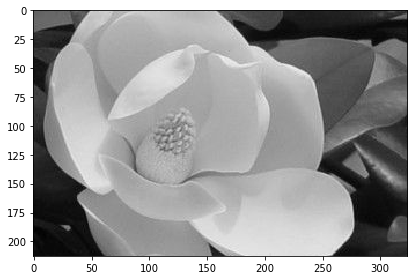

In [7]:
io.imshow(g_img)

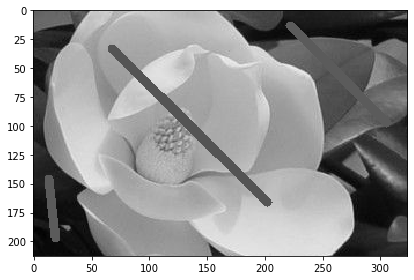

In [8]:
io.imshow(g_img_s)

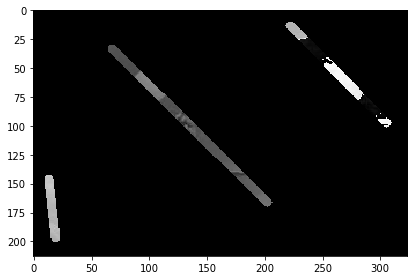

In [9]:
diff = g_img - g_img_s
io.imshow(diff)
io.imsave('diff.png', diff)

In [10]:
scribble_diff = []
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        if diff[i,j] > 0:
            scribble_diff.append((i,j))
# print(scribble_diff)

In [11]:
scribble == scribble_diff # Need to see why 

True

In [12]:
img_s_key = set()
rgb_s = mpimg.imread(img_file_scribbled)[:,:,:3]
yuv_s = rgb2yiq(rgb_s)
for i, j in scribble:
    img_s_key.add(tuple(rgb_s[i,j,:3]))
img_s_key # should only have two values
# Need to check that the scribbles are purely a single colour and do not shade at the edges

{(0.24705882, 0.28235295, 0.8), (0.92941177, 0.10980392, 0.14117648)}

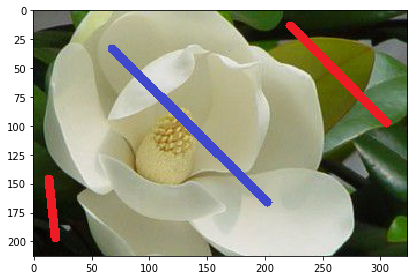

In [13]:
io.imshow(img_s)

In [14]:
def find_marked_locations(rgb, rgb_s):
    g = cv2.cvtColor(io.imread(rgb), cv2.COLOR_RGB2GRAY)
    g_s = cv2.cvtColor(io.imread(rgb_s), cv2.COLOR_RGB2GRAY)
    scribble = []
    non_scribble = []
    for i in range(g.shape[0]):
        for j in range(g.shape[1]):
            if g[i,j] !=  g_s[i,j]:
                scribble.append((i, j))
            else:
                non_scribble.append((i, j))
    return scribble, non_scribble

In [15]:
def compute_pdfs(imfile, imfile_scrib):
    rgb = mpimg.imread(imfile)[:,:,:3]
    yuv = rgb2yiq(rgb)
    rgb_s = mpimg.imread(imfile_scrib)[:,:,:3]
    yuv_s = rgb2yiq(rgb_s)
    print(yuv.shape)
    print(yuv[0])
    # io.imshow(rgb)
    # io.imshow(rgb_s)
        
    # find the scribble pixels    
    # scribbles = find_marked_locations(rgb, rgb_s)
    scribbles, _ = find_marked_locations(imfile, imfile_scrib)
    if not scribbles:
        raise Exception

    imageo = np.zeros(yuv.shape)
    
    # separately store background and foreground scribble pixels in the dictionary comps
    comps = defaultdict(lambda:np.array([]).reshape(0,3))
    for (i, j) in scribbles:
         imageo[i,j,:] = rgb_s[i,j,:]
         # scribble color as key of comps
         comps[tuple(imageo[i,j,:])] = np.vstack([comps[tuple(imageo[i,j,:])], yuv[i,j,:]])
    mu, sigma = {}, {}
    # compute MLE parameters for Gaussians
    for c in comps:
         mu[c] = np.mean(comps[c], axis=0)
         sigma[c] = np.cov(comps[c].T)
    return (mu, sigma)

In [16]:
# Check to see what they mean
m, s = compute_pdfs(img_file, img_file_scribbled)

(213, 324, 3)
[[ 3.80458831e-01  5.22416804e-03 -8.15190104e-03]
 [ 3.88301967e-01  5.22416804e-03 -8.15190112e-03]
 [ 3.84380399e-01  5.22416804e-03 -8.15190108e-03]
 [ 3.88301967e-01  5.22416804e-03 -8.15190112e-03]
 [ 3.88301967e-01  5.22416804e-03 -8.15190112e-03]
 [ 3.84380399e-01  5.22416804e-03 -8.15190108e-03]
 [ 3.80458831e-01  5.22416804e-03 -8.15190104e-03]
 [ 3.80458831e-01  5.22416804e-03 -8.15190104e-03]
 [ 3.88301967e-01  5.22416804e-03 -8.15190112e-03]
 [ 3.92223536e-01  5.22416804e-03 -8.15190116e-03]
 [ 3.88580399e-01  1.00813773e-02 -9.76312648e-03]
 [ 3.88580399e-01  1.00813773e-02 -9.76312648e-03]
 [ 3.92501967e-01  1.00813773e-02 -9.76312652e-03]
 [ 3.96423536e-01  1.00813773e-02 -9.76312656e-03]
 [ 3.96423536e-01  1.00813773e-02 -9.76312656e-03]
 [ 4.00345104e-01  1.00813773e-02 -9.76312659e-03]
 [ 4.02858829e-01  8.63772572e-03 -5.27240035e-03]
 [ 4.02858829e-01  8.63772572e-03 -5.27240035e-03]
 [ 3.91094124e-01  8.63772572e-03 -5.27240023e-03]
 [ 3.91094124e-01

In [17]:
m

{(0.929411768913269,
  0.10980392247438431,
  0.1411764770746231): array([ 0.23677415,  0.04043869, -0.07256445]),
 (0.24705882370471954,
  0.2823529541492462,
  0.800000011920929): array([ 0.69577409,  0.05567166, -0.04190303])}

In [18]:
s

{(0.929411768913269,
  0.10980392247438431,
  0.1411764770746231): array([[ 0.02069629,  0.00378414, -0.00637799],
        [ 0.00378414,  0.00300122, -0.00178314],
        [-0.00637799, -0.00178314,  0.00228502]]),
 (0.24705882370471954,
  0.2823529541492462,
  0.800000011920929): array([[ 0.00535723, -0.00165761,  0.00094871],
        [-0.00165761,  0.00145263, -0.00064738],
        [ 0.00094871, -0.00064738,  0.00034484]])}

In [19]:
import scipy.stats as ss 
pixel_val = rgb_s[0,200,:]
var0 = ss.multivariate_normal.pdf(pixel_val, [ 0.23677415,  0.04043869, -0.07256445], [[ 0.02069629,  0.00378414, -0.00637799],
        [ 0.00378414,  0.00300122, -0.00178314],
        [-0.00637799, -0.00178314,  0.00228502]])
var0

3.334576564358832e-57

In [20]:
var1 = ss.multivariate_normal.pdf(pixel_val, [ 0.69577409,  0.05567166, -0.04190303], [[ 0.00535723, -0.00165761,  0.00094871],
        [-0.00165761,  0.00145263, -0.00064738],
        [ 0.00094871, -0.00064738,  0.00034484]])
var1

1.9276459986647832e-295

In [21]:
var2 = var0 + var1
print(var1, ": ",var2)
print(var0/var2, var1/var2) # Source and Sink Weights 

1.9276459986647832e-295 :  3.334576564358832e-57
1.0 5.780781941755859e-239


In [22]:
def assign_scribble_pixels():
    scribbles_pos, _ = find_marked_locations(img_file, img_file_scribbled)
    scribbles_pos_dict = defaultdict(list)
    rgb_s = mpimg.imread(img_file_scribbled)[:,:,:3]
    for pos in scribbles_pos:
        if tuple(rgb_s[pos[0], pos[1]]) in img_s_key:
            scribbles_pos_dict[tuple(rgb_s[pos[0], pos[1]])].append(pos)
    
    # Sanity Check 
    print(len(scribbles_pos_dict))
    l = 0
    for k in scribbles_pos_dict:
        l += len(scribbles_pos_dict[k])
    
    if l == len(scribbles_pos):
        print('OK')
    # ------------
    return scribbles_pos_dict

scribbles_pos_dict = assign_scribble_pixels()

2
OK


## Constructing Graph for QA with Source and Sink nodes

In [23]:
s_J = {}
r, c = g_img.shape[:2]
print("c = ",r*c)
k1, k2 = list(scribbles_pos_dict.keys())

for pos in scribbles_pos_dict[k1]:
    s_J[(pos[0]*c + pos[1], 's')] = 1
    s_J[(pos[0]*c + pos[1], 't')] = 0

for pos in scribbles_pos_dict[k2]:
    s_J[(pos[0]*c + pos[1], 't')] = 1
    s_J[(pos[0]*c + pos[1], 's')] = 0  


c =  69012


In [24]:
scribbled_pos, non_scribbles_pos = find_marked_locations(img_file, img_file_scribbled)
print(len(non_scribbles_pos))
assert (len(scribbled_pos) + len(non_scribbles_pos)) == r*c
(len(scribbled_pos) + len(non_scribbles_pos))

66027


69012

In [25]:
## assigning total_pixel - scribble_pixels probabilities of background or foreground using PDF function

In [26]:
rgb_s = mpimg.imread(img_file_scribbled)[:,:,:3]
print(rgb_s[0,0,:])
print("************* ",len(non_scribbles_pos))
non_s_j = {}
rgb = mpimg.imread(img_file)[:,:,:3]
cnt = 0
for i, pos in enumerate(non_scribbles_pos):
    
    var0 = ss.multivariate_normal.pdf(rgb[pos[0],pos[1],:], m[k1], s[k1])
    var1 = ss.multivariate_normal.pdf(rgb[pos[0],pos[1],:], m[k2], s[k2])
    res = var0 + var1

    #print("******** got var1: {}, var2: {}".format(var0, var1))
    res0 = var0/res
    res1 = var1/res
    #print("var0: {} var1:{} res0:{}, res1:{} ".format(var0, var1, res0, res1))
    import math
    if math.isnan(res0) or math.isnan(res1):
        print("var0: {} var1:{} res0:{}, res1:{} ".format(var0, var1, res0, res1))
        print("pos: {}", pos)
        cnt += 1
        res0 = 0
        res1 = 0
        #break
    non_s_j[(pos[0]*c + pos[1], 's')] = res0
    non_s_j[(pos[0]*c + pos[1], 't')] = res1
    #print(res0, " : ", res1)
print("total:{} nane:{}".format(i, cnt))








os: {} (211, 88)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 89)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 90)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 91)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 92)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 93)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 94)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 95)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 96)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 97)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 98)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 99)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 100)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 101)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 102)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 103)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 104)
var0: 0.0 var1:0.0 res0:nan, res1:nan 
pos: {} (211, 105)
var0: 0.

In [27]:
rgb[0,0,:]
ss.multivariate_normal.pdf(rgb[82,82,:], m[k2], s[k2])
#total:66026 nane:47191
print((len(scribbled_pos)))
print(66026-47191)

2985
18835


--------------------------------------------------
## Constructing Graph for QA from g_img Intensities

In [28]:
for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        pass
print(i, j, pxij)
g_img[0,0]

212 323 45


97

In [29]:
import math
import dimod
img = io.imread('test2.png')
g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
std = np.std(g_img)
std

64.28870987696376

#### Constructing QUBO Model BQM

In [30]:
from tqdm import tqdm
r, c = g_img.shape[:2]
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        # Just putting Intensity for now
        bqm.add_variable(i*c + j, pxij)

for i, pxi in tqdm(enumerate(g_img)):
    for j, pxij in enumerate(pxi):
        # print(i , j)
        if i-1 >= 0:
            #Up
            a, b = i*c + j, (i-1)*c + j
            # print('UP:', a, b)
            Ia, Ib = pxij, g_img[i-1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if i+1 < r:
            #Down
            a, b = i*c + j, (i+1)*c + j
            # print('DOWN:', a, b)
            Ia, Ib = pxij, g_img[i+1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if j-1 >= 0:
            #Left
            a, b = i*c + j, i*c + (j-1)
            # print('LEFT:', a, b)
            Ia, Ib = pxij, g_img[i, j-1]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if j+1 < c:
            #Right
            a, b = i*c + j, i*c + (j+1)
            # print('RIGHT:', a, b)
            Ia, Ib = pxij, g_img[i, j+1]
            power = ((Ia-Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))

213it [00:12, 17.55it/s]


#### Constructing Spin/Ising Model BQM

In [40]:
h = {'s': 0, 't': 0}
J = {}

for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        # # Just putting Intensity for now
        # h[i*c + j] = pxij
        h[i*c + j] = 0

for i, pxi in tqdm(enumerate(g_img)):
    for j, pxij in enumerate(pxi):
        # print(i , j)
        if i-1 >= 0:
            #Up
            a, b = i*c + j, (i-1)*c + j
            # print('UP:', a, b)
            Ia, Ib = pxij, g_img[i-1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)
        if i+1 < r:
            #Down
            a, b = i*c + j, (i+1)*c + j
            # print('DOWN:', a, b)
            Ia, Ib = pxij, g_img[i+1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)
        if j-1 >= 0:
            #Left
            a, b = i*c + j, i*c + (j-1)
            # print('LEFT:', a, b)
            Ia, Ib = pxij, g_img[i, j-1]
            power = ((Ia -Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)
        if j+1 < c:
            #Right
            a, b = i*c + j, i*c + (j+1)
            # print('RIGHT:', a, b)
            Ia, Ib = pxij, g_img[i, j+1]
            power = ((Ia-Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)

213it [00:07, 28.72it/s]


In [32]:
len(h)

69012

In [33]:
len(J)

274974

In [42]:
# J

In [35]:
'''import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import networkx as nx
import sys

from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, Label, LabelSet, ColumnDataSource
from bokeh.models import WheelZoomTool, ZoomInTool, ZoomOutTool, ResetTool, PanTool
from bokeh.models.graphs import from_networkx

def plot_bqm(bqm):
    """Plot binary quadratic model as a labeled graph."""
    g = nx.Graph()
    g.add_nodes_from(bqm.variables)
    g.add_edges_from(bqm.quadratic)    
    plot_size = 400
    text_size = '16pt'
     
    graph = from_networkx(g, nx.spring_layout)
    graph.node_renderer.glyph = Circle(size=35, fill_color='purple', fill_alpha=0.25)
    graph.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=2)
 
    pos = nx.spring_layout(g)
    data = {'xpos': [], 'ypos': [], 'label': []}
    for label, loc in pos.items():
        data['label'].append(label)
        data['xpos'].append(loc[0])
        data['ypos'].append(loc[1])
    labels = LabelSet(x='xpos', y='ypos', text='label', level='glyph', 
                      source=ColumnDataSource(data), x_offset=-1, y_offset=-1, 
                      text_color="blue", text_font_size='14pt', text_font_style='bold')    
    
    plot = Plot(plot_width=plot_size, plot_height=plot_size, x_range=Range1d(-1.3, 1.3), y_range=Range1d(-1.3, 1.3))
    plot.title.text = "BQM with {} nodes and {} edges".format(len(bqm), len(bqm.quadratic))
    
    tools = [WheelZoomTool(), ZoomInTool(), ZoomOutTool(), PanTool(), ResetTool()]
    plot.add_tools(*tools)
    plot.toolbar.active_scroll = tools[0]
    
    plot.renderers.append(graph)
    plot.add_layout(labels)
    plot.background_fill_color = "lightyellow"
        
    show(plot)
    '''

'import matplotlib.pyplot as plt\nimport matplotlib.colors as colors\nimport numpy as np\nimport networkx as nx\nimport sys\n\nfrom bokeh.io import show, output_notebook\nfrom bokeh.models import Plot, Range1d, MultiLine, Circle, Label, LabelSet, ColumnDataSource\nfrom bokeh.models import WheelZoomTool, ZoomInTool, ZoomOutTool, ResetTool, PanTool\nfrom bokeh.models.graphs import from_networkx\n\ndef plot_bqm(bqm):\n    """Plot binary quadratic model as a labeled graph."""\n    g = nx.Graph()\n    g.add_nodes_from(bqm.variables)\n    g.add_edges_from(bqm.quadratic)    \n    plot_size = 400\n    text_size = \'16pt\'\n     \n    graph = from_networkx(g, nx.spring_layout)\n    graph.node_renderer.glyph = Circle(size=35, fill_color=\'purple\', fill_alpha=0.25)\n    graph.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=2)\n \n    pos = nx.spring_layout(g)\n    data = {\'xpos\': [], \'ypos\': [], \'label\': []}\n    for label, loc in pos.items():\n        data[\'label\'].append(lab

In [36]:
#plot_bqm(bqm)

In [37]:

res_J = dict(s_J)
res_J.update(non_s_j)
res_J.update(J)
print(len(res_J))

412998


In [38]:
r * c

69012

In [39]:
2 * r * c + (4 * r * c)

414072

In [54]:
print("\nSimulated Annealing....")
import neal
qpu = neal.SimulatedAnnealingSampler()
result = qpu.sample_ising(h={}, J=res_J, num_reads=10)
result.first[0]


Simulated Annealing....


{3460: -1,
 's': -1,
 't': 1,
 3461: 1,
 3462: -1,
 3463: 1,
 3464: -1,
 3783: -1,
 3784: 1,
 3785: -1,
 3786: 1,
 3787: -1,
 3788: 1,
 3789: -1,
 4107: 1,
 4108: -1,
 4109: 1,
 4110: -1,
 4111: 1,
 4112: -1,
 4113: 1,
 4114: 1,
 4430: 1,
 4431: -1,
 4432: 1,
 4433: -1,
 4434: 1,
 4435: -1,
 4436: 1,
 4437: -1,
 4438: -1,
 4439: 1,
 4755: 1,
 4756: -1,
 4757: 1,
 4758: -1,
 4759: 1,
 4760: -1,
 4761: 1,
 4762: 1,
 4763: -1,
 4764: 1,
 5079: -1,
 5080: 1,
 5081: -1,
 5082: 1,
 5083: -1,
 5084: 1,
 5085: 1,
 5086: -1,
 5087: 1,
 5088: -1,
 5089: 1,
 5404: -1,
 5405: 1,
 5406: -1,
 5407: 1,
 5408: -1,
 5409: -1,
 5410: 1,
 5411: -1,
 5412: 1,
 5413: -1,
 5414: 1,
 5729: -1,
 5730: 1,
 5731: -1,
 5732: 1,
 5733: 1,
 5734: -1,
 5735: 1,
 5736: -1,
 5737: 1,
 5738: -1,
 5739: 1,
 6054: -1,
 6055: 1,
 6056: -1,
 6057: 1,
 6058: 1,
 6059: -1,
 6060: 1,
 6061: -1,
 6062: 1,
 6063: -1,
 6064: 1,
 6379: -1,
 6380: 1,
 6381: 1,
 6382: -1,
 6383: 1,
 6384: -1,
 6385: 1,
 6386: -1,
 6387: 1,
 6388: 

In [49]:
# res_img = np.copy(g_img)
# for i, pxi in tqdm(enumerate(g_img)):
#     for j, pxij in enumerate(pxi):
#         if result.first[0][i*c + j] == -1:
#             res_img[i,j] = 0
# io.imshow(res_img)

In [60]:
sol = result.first[0].copy()
del sol['s']
del sol['t']
sol = dict(sorted(sol.items())).copy()
result_img = np.array(list(sol.values()))
result_img.shape


(69012,)

In [69]:
result_img

array([[-1,  1, -1, ..., -1,  1, -1],
       [ 1, -1,  1, ...,  1, -1,  1],
       [-1,  1, -1, ..., -1,  1, -1],
       ...,
       [-1,  1, -1, ...,  1,  1, -1],
       [ 1, -1,  1, ..., -1,  1, -1],
       [-1,  1, -1, ...,  1, -1,  1]], dtype=int8)

In [64]:
result_img = result_img.reshape((r, c))
result_img.shape

(213, 324)

In [71]:
final_img = np.where(result_img > 0, result_img, 0)

In [75]:
final_img = final_img * g_img

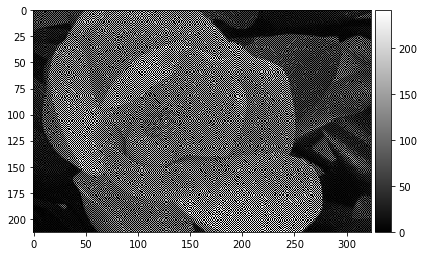

In [76]:
io.imshow(final_img, cmap='gray')